In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import logging
from eden.util import configure_logging
logger = logging.getLogger()
configure_logging(logger, verbosity=1)

## Plan
- take a predictive task on graphs, like PubChem
- visualize some molecules
- relabel them

In [3]:
assay_id = '624466' #apr88
assay_id = '1847'   #apr83
assay_id = '588350' #apr86 p1k n600
assay_id = '119'    #apr60 30k mols
assay_id = '588794' #apr76 p1k n1k
assay_id = '624325' #apr79

In [4]:
from toolz import curry

from eden_chem.io.pubchem import download
download_active = curry(download)(active=True)
download_inactive = curry(download)(active=False)

from eden_chem.obabel import load as babel_load
from toolz import memoize
@memoize
def get_active_graphs(assay_id):
    return pipe(assay_id, download_active, babel_load, list)
@memoize
def get_inactive_graphs(assay_id):
    return pipe(assay_id, download_inactive, babel_load, list)

Draw sample
Active


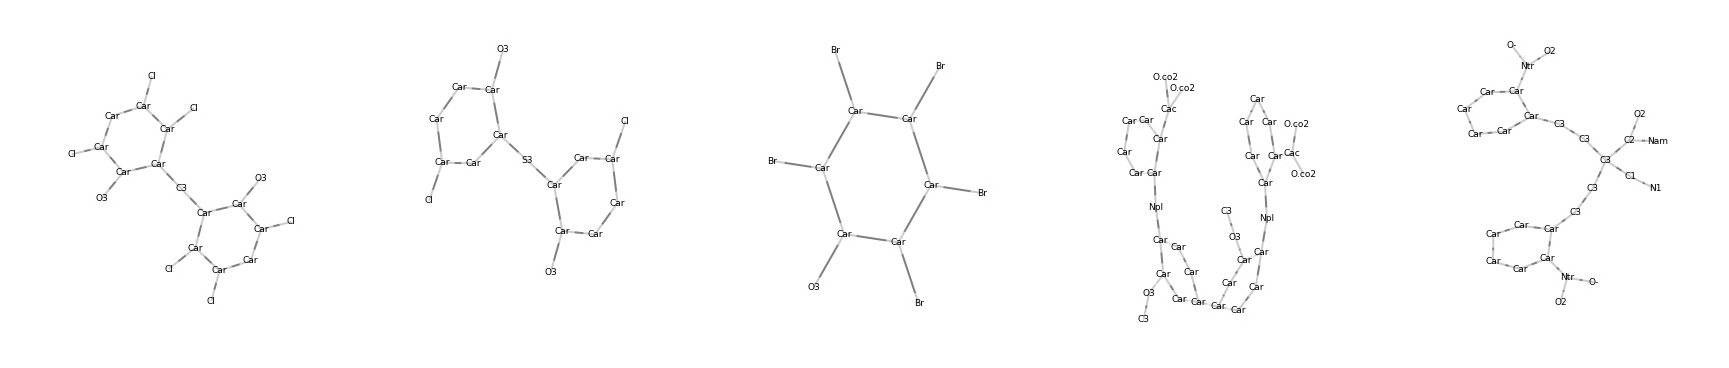

In [5]:
from toolz import curry

from eden_chem.io.pubchem import download
download_active = curry(download)(active=True)
download_inactive = curry(download)(active=False)

from eden_chem.obabel import load as babel_load

from toolz import take
ctake_few = curry(take)(5)

from eden.display import draw_graph_set
cdraw_graph_set = curry(draw_graph_set)(n_graphs_per_line=5, size=6)

print 'Draw sample'

print 'Active'
from toolz import pipe
pipe(assay_id, download_active, babel_load, ctake_few, cdraw_graph_set)

In [6]:
def clean_label(orig_graph):
    graph = orig_graph.copy()
    for u in graph.nodes():
        graph.node[u]['label']='_'
    for e in graph.edges_iter():
        graph.edge[e[0]][e[1]]['label']='_'
    return graph

In [7]:
%%time
graphs = get_active_graphs(assay_id)

from toolz.curried import map
from eden.graph import auto_relabel

auto_relabel_ = curry(auto_relabel)(n_clusters=3, complexity=3)    
relabled_graphs = pipe(graphs, map(clean_label), auto_relabel_)

CPU times: user 42.2 s, sys: 2.17 s, total: 44.4 s
Wall time: 9.57 s


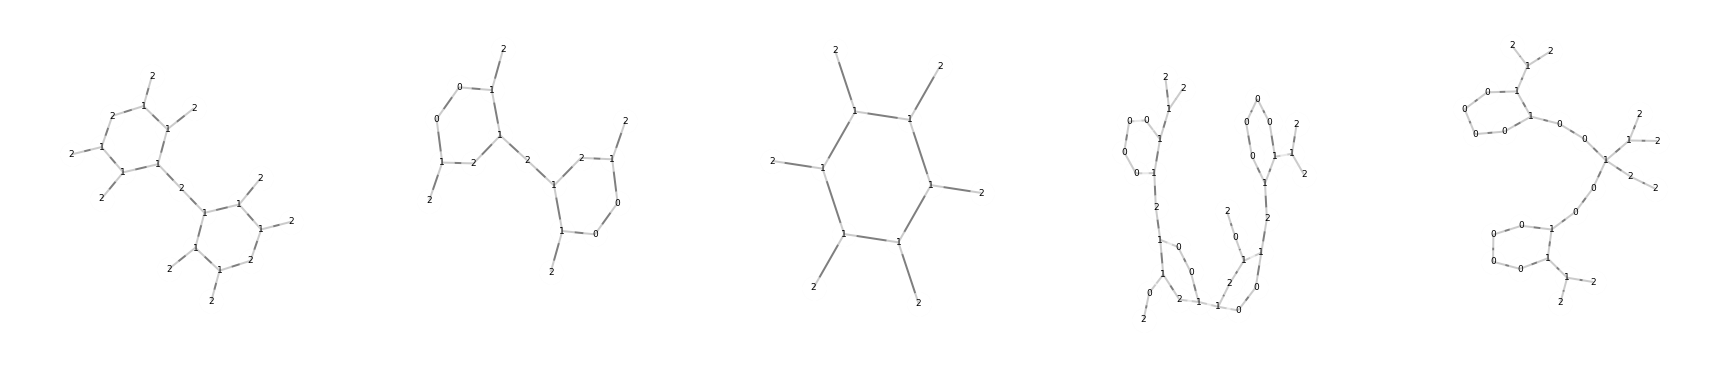

In [8]:
pipe(relabled_graphs, ctake_few, cdraw_graph_set)

In [9]:
# map graphs to vectors
from eden.graph import vectorize
cvectorize = curry(vectorize)(complexity=4, nbits=17)

@memoize
def get_active_vecs(assay_id):
    return pipe(assay_id, get_active_graphs, cvectorize)
@memoize
def get_inactive_vecs(assay_id):
    return pipe(assay_id, get_inactive_graphs, cvectorize)


import numpy as np
from scipy.sparse import vstack
from sklearn.linear_model import SGDClassifier

def make_data(assay_id):
    active_X = get_active_vecs(assay_id)
    inactive_X = get_inactive_vecs(assay_id)
    X = vstack((active_X, inactive_X))
    y = np.array([1]*active_X.shape[0] + [0]*inactive_X.shape[0])
    return X, y

import numpy as np
from scipy.sparse import vstack
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

def predictive_performance(estimator, data):
    X, y = data
    cv = ShuffleSplit(n_splits=15, test_size=0.3, random_state=34)
    scoring = make_scorer(average_precision_score)
    scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
    return scores

from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(average=True, class_weight='balanced', shuffle=True, n_jobs=-1)
predictive_performance_ = curry(predictive_performance)(sgd)


def output_avg_and_std(scores):
    print('Acc: %.3f ±%.3f' % (np.mean(scores),np.std(scores)))
    
def output_stats(scores):
    mean, std = np.mean(scores), np.std(scores)
    median, low, high = np.percentile(scores, 50), np.percentile(scores, 25), np.percentile(scores, 75)       
    low10, high90 = np.percentile(scores, 10), np.percentile(scores, 90)       
    print '  score=%.2f ±%.2f [%.2f|%.2f|%.2f]' % (mean, std, low, median, high),
    return median, low, high, low10, high90

    
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from eden.display import plot_confusion_matrices
from eden.display import plot_aucs

from sklearn.model_selection import train_test_split
    
def train(estimator, data):
    X, y = data
    return estimator.fit(X, y)

def test(estimator, X):
    y_pred = estimator.predict(X)
    y_score = estimator.decision_function(X)
    return y_pred, y_score

def train_and_test(estimator, data):
    X, y = data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    fit_estimator = train(estimator, (X_train, y_train))
    y_pred, y_score = test(fit_estimator, X_test)
    return y_test, y_pred, y_score


from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(average=True, class_weight='balanced', shuffle=True, n_jobs=-1)
train_and_test_ = curry(train_and_test)(sgd)

def predictive_performance_report(data):
    y_true, y_pred, y_score = data
    print
    print 'Accuracy: %.2f' % accuracy_score(y_true, y_pred)
    print ' AUC ROC: %.2f' % roc_auc_score(y_true, y_score)
    print '  AUC AP: %.2f' % average_precision_score(y_true, y_score)
    print
    print 'Classification Report:'
    print classification_report(y_true, y_pred)
    print
    plot_confusion_matrices(y_true, y_pred, size=int(len(set(y_true))*2.5))
    print
    plot_aucs(y_true, y_score, size=10)

## Case: original labels


Accuracy: 0.76
 AUC ROC: 0.84
  AUC AP: 0.78

Classification Report:
             precision    recall  f1-score   support

          0       0.77      0.79      0.78       406
          1       0.74      0.72      0.73       338

avg / total       0.76      0.76      0.76       744




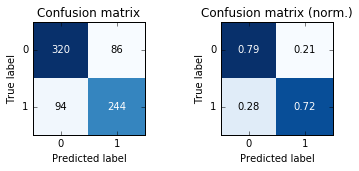

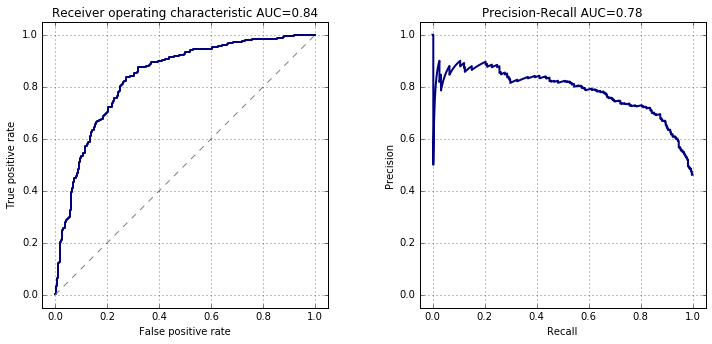

In [10]:
pipe(assay_id, make_data, train_and_test_, predictive_performance_report)

## Case: clear node and edge labels


Accuracy: 0.78
 AUC ROC: 0.82
  AUC AP: 0.76

Classification Report:
             precision    recall  f1-score   support

          0       0.78      0.82      0.80       406
          1       0.77      0.73      0.75       338

avg / total       0.78      0.78      0.78       744




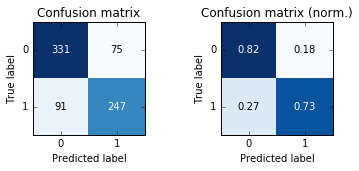

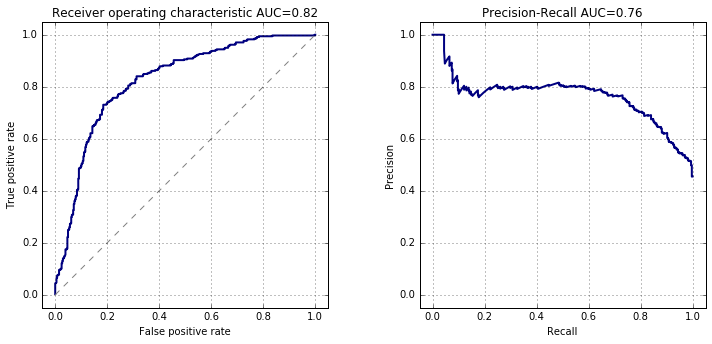

In [11]:
from eden.graph import auto_relabel

def make_data_clear_label(assay_id):
    active_graphs = get_active_graphs(assay_id)
    inactive_graphs = get_inactive_graphs(assay_id)
    graphs = active_graphs + inactive_graphs
    X = pipe(graphs, map(clean_label), cvectorize)
    y = np.array([1]*len(active_graphs) + [0]*len(inactive_graphs))
    return X, y

pipe(assay_id, make_data_clear_label, train_and_test_, predictive_performance_report)

## Case: clear labels and do relabel 

In [12]:
from eden.graph import auto_relabel

def make_data_relabel(assay_id, n_clusters=8, complexity=4):
    active_graphs = get_active_graphs(assay_id)
    inactive_graphs = get_inactive_graphs(assay_id)
    graphs = active_graphs + inactive_graphs
    auto_relabel_ = curry(auto_relabel)(n_clusters=n_clusters, complexity=complexity)    
    X = pipe(graphs, map(clean_label), auto_relabel_, cvectorize)
    y = np.array([1]*len(active_graphs) + [0]*len(inactive_graphs))
    return X, y


Accuracy: 0.77
 AUC ROC: 0.83
  AUC AP: 0.78

Classification Report:
             precision    recall  f1-score   support

          0       0.79      0.78      0.79       406
          1       0.74      0.75      0.75       338

avg / total       0.77      0.77      0.77       744




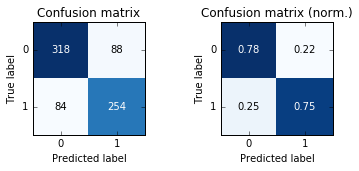

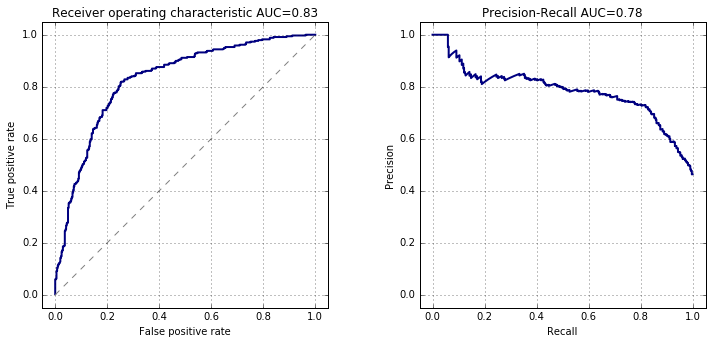

In [13]:
make_data_relabel_ = curry(make_data_relabel)(n_clusters=2)
pipe(assay_id, make_data_relabel_, train_and_test_, predictive_performance_report)


Accuracy: 0.76
 AUC ROC: 0.82
  AUC AP: 0.76

Classification Report:
             precision    recall  f1-score   support

          0       0.78      0.80      0.79       406
          1       0.75      0.73      0.74       338

avg / total       0.76      0.76      0.76       744




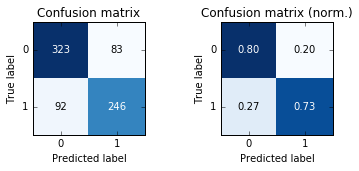

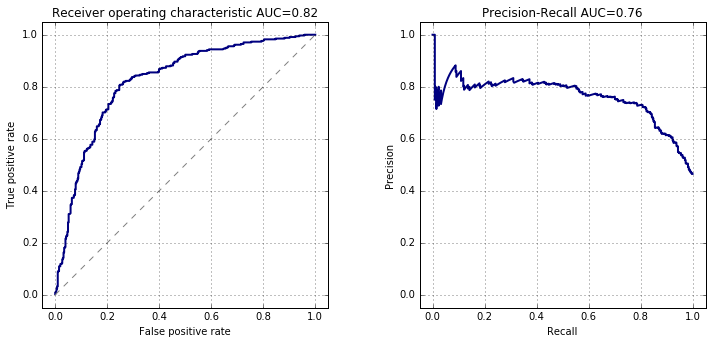

In [14]:
make_data_relabel_ = curry(make_data_relabel)(n_clusters=30)
pipe(assay_id, make_data_relabel_, train_and_test_, predictive_performance_report)

## Case: clear labels, do relabel, analyze effect of num clusters

In [21]:
from math import ceil
import numpy as np
from scipy import linalg

def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

import pylab as plt
import numpy as np

def plot_stats(x=None,y=None, xlabel='', ylabel='', title='', label='', interpolation=False):
    plt.figure(figsize=(15,6))
    y = np.array(y)
    y0 = y[:,0]
    y1 = y[:,1]
    y2 = y[:,2]
    y3 = y[:,3]
    y4 = y[:,4]
    if interpolation:
        ye = lowess(np.array(x),y0, f=0.3)
    ye = y0
    plt.fill_between(x, y3, y4, color='navy', alpha=0.08)
    plt.fill_between(x, y1, y2, color='navy', alpha=0.08)
    plt.plot(x,y0,'-', lw=2, color='navy', label=label)
    if interpolation:
        plt.plot(x,ye,'-', lw=3, color='r', label='lowess interpolation')
    plt.plot(x,y0,
             linestyle='None',
             markerfacecolor='white',
             markeredgecolor='navy',
             marker='o',
             markeredgewidth=2,
             markersize=8)
    plt.xticks(pipe(x,map(int),list))
    #plt.ylim((.4,1))
    plt.grid(linestyle=":")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

In [22]:
import time
def cluster_analysis(n_cluster_list):
    xs = []
    ys = []
    for n_clusters in n_cluster_list:
        ts = time.time()
        print 'num clusters=%3d' % n_clusters, 
        make_data_relabel_ = curry(make_data_relabel)(n_clusters=n_clusters)
        y = pipe(assay_id, make_data_relabel_, predictive_performance_, output_stats)
        ys.append(y)
        xs.append(n_clusters)
        te = time.time()
        print ' %3.1f sec' % (te-ts)
    plot_stats(xs,ys,  
               xlabel='num clusters', 
               ylabel='AUC APR', 
               title= 'Num clusters Analysis', 
               label= 'median+-quantiles')

num clusters=  2   score=0.79 ±0.01 [0.79|0.79|0.80]  28.5 sec
num clusters=  3   score=0.79 ±0.01 [0.78|0.79|0.80]  27.9 sec
num clusters=  6   score=0.79 ±0.01 [0.78|0.79|0.80]  26.4 sec
num clusters=  8   score=0.80 ±0.01 [0.79|0.80|0.81]  27.0 sec
num clusters=  9   score=0.79 ±0.01 [0.78|0.79|0.80]  27.5 sec
num clusters= 10   score=0.79 ±0.01 [0.79|0.79|0.80]  29.2 sec
num clusters= 11   score=0.79 ±0.01 [0.78|0.79|0.80]  28.9 sec
num clusters= 12   score=0.79 ±0.01 [0.79|0.79|0.80]  27.8 sec
num clusters= 14   score=0.79 ±0.01 [0.78|0.79|0.80]  29.8 sec
num clusters= 16   score=0.79 ±0.01 [0.78|0.79|0.80]  31.0 sec
num clusters= 18   score=0.79 ±0.01 [0.78|0.79|0.80]  30.7 sec
num clusters= 20   score=0.79 ±0.01 [0.78|0.79|0.80]  35.5 sec


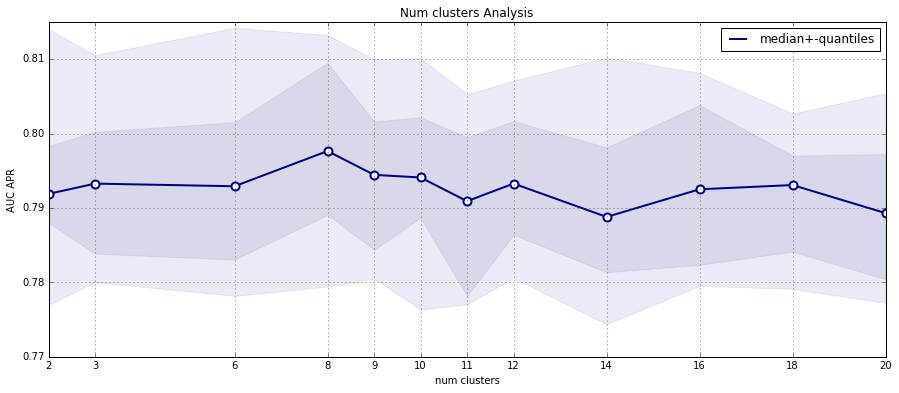

CPU times: user 45min 23s, sys: 2min 2s, total: 47min 26s
Wall time: 5min 50s


In [23]:
%%time
cluster_analysis([2,3,6,8,9,10,11,12,14,16,18,20])

num clusters= 20   score=0.79 ±0.01 [0.78|0.79|0.80]  33.3 sec
num clusters= 30   score=0.79 ±0.01 [0.78|0.80|0.80]  36.6 sec
num clusters= 40   score=0.79 ±0.01 [0.78|0.79|0.80]  35.7 sec
num clusters= 50   score=0.79 ±0.01 [0.78|0.79|0.79]  39.2 sec
num clusters= 60   score=0.79 ±0.01 [0.78|0.78|0.80]  42.6 sec
num clusters= 70   score=0.79 ±0.01 [0.78|0.79|0.79]  48.1 sec
num clusters= 80   score=0.79 ±0.01 [0.78|0.78|0.79]  49.5 sec


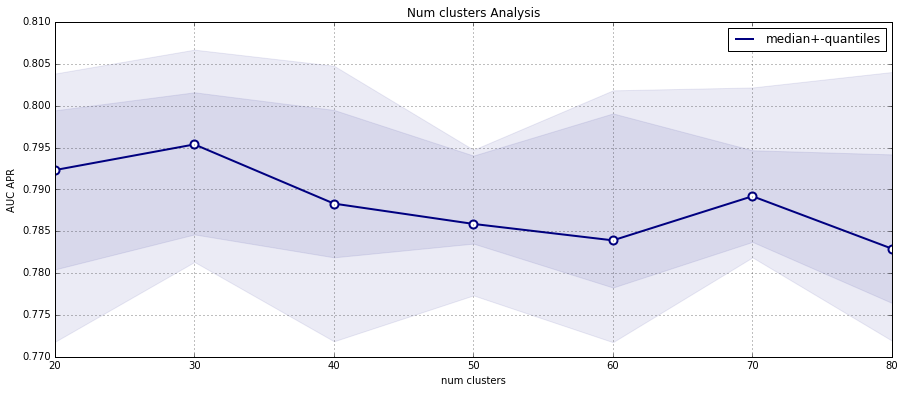

CPU times: user 1h 7min 10s, sys: 2min, total: 1h 9min 10s
Wall time: 4min 45s


In [24]:
%%time
cluster_analysis([20,30,40,50,60,70,80])

num clusters=  2   score=0.79 ±0.01 [0.78|0.80|0.80]  26.2 sec
num clusters=  4   score=0.79 ±0.01 [0.79|0.79|0.80]  25.8 sec
num clusters=  8   score=0.79 ±0.01 [0.78|0.79|0.80]  27.0 sec
num clusters= 16   score=0.79 ±0.01 [0.79|0.80|0.80]  30.6 sec
num clusters= 32   score=0.79 ±0.01 [0.78|0.79|0.79]  38.0 sec
num clusters= 64   score=0.79 ±0.01 [0.78|0.79|0.80]  44.5 sec
num clusters=128   score=0.79 ±0.01 [0.78|0.78|0.79]  59.2 sec
num clusters=256   score=0.79 ±0.01 [0.77|0.78|0.79]  90.5 sec


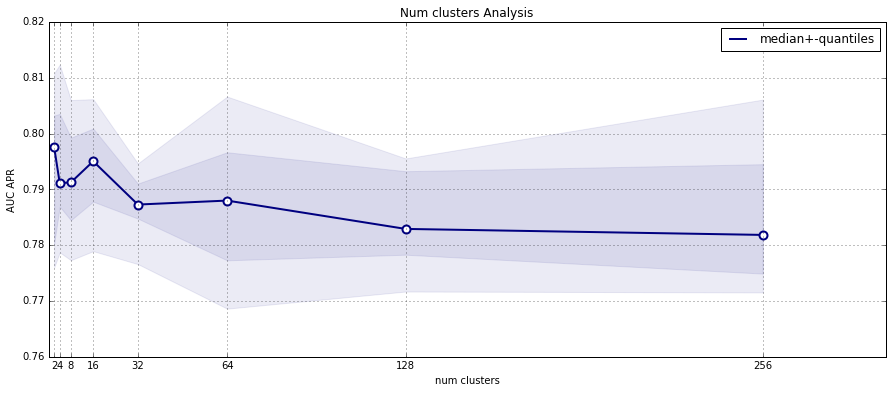

CPU times: user 1h 24min 52s, sys: 2min 20s, total: 1h 27min 13s
Wall time: 5min 42s


In [25]:
%%time
cluster_analysis([2,4,8,16,32,64,128,256])

---